## ALE plots

In [1]:
import sys
sys.path

['c:\\D_Drive\\Indra\\github_projects\\explainability\\PyALE-master\\decoding',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\python311.zip',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\DLLs',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01',
 '',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages\\win32',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages\\Pythonwin']

In [2]:
alepath="C:\D_Drive\Indra\github_projects\explainability\PyALE-master"
sys.path.insert(0,alepath)
sys.path

['C:\\D_Drive\\Indra\\github_projects\\explainability\\PyALE-master',
 'c:\\D_Drive\\Indra\\github_projects\\explainability\\PyALE-master\\decoding',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\python311.zip',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\DLLs',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01',
 '',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages\\win32',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages\\Pythonwin']

In [3]:
from PyALE import ale, ALE_1D_IS, ALE_1D, ALE_2D, lib

In [4]:
ALE_1D_IS.fn_check()

2024-05-01 22:40:04.041 | INFO     | PyALE._src.ALE_1D_IS:fn_check:18 - In the fn_check method
2024-05-01 22:40:04.043 | DEBUG    | PyALE._src.ALE_1D_IS:fn_check:20 - A debug message.
2024-05-01 22:40:04.043 | INFO     | PyALE._src.ALE_1D_IS:fn_check:21 - An info message.
2024-05-01 22:40:04.044 | SUCCESS  | PyALE._src.ALE_1D_IS:fn_check:22 - A success message.
2024-05-01 22:40:04.044 | WARNING  | PyALE._src.ALE_1D_IS:fn_check:23 - A warning message.
2024-05-01 22:40:04.047 | ERROR    | PyALE._src.ALE_1D_IS:fn_check:24 - An error message.
2024-05-01 22:40:04.047 | CRITICAL | PyALE._src.ALE_1D_IS:fn_check:25 - A critical message.


# PyALE: Usage examples

In [5]:
import pandas as pd
pd.set_option("display.max_columns",None)
pd.set_option("display.max_colwidth",None)
import random
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

## Prepare Data

In [6]:
# get the raw diamond data (from R's ggplot2)
# dat_diamonds = pd.read_csv(
#     "https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/diamonds.csv"
# )
dat_diamonds = pd.read_csv(".\Input_Data\diamonds.csv")
dat_diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [7]:
X_raw = dat_diamonds.loc[:, ~dat_diamonds.columns.str.contains("price")].copy()
y = dat_diamonds["price"].copy()

In [8]:
X = X_raw.copy()
# convert the three text columns to ordered categoricals
X["cut"] = X["cut"].astype(
    pd.api.types.CategoricalDtype(
        categories=["Fair", "Good", "Very Good", "Premium", "Ideal"], ordered=True
    )
)
X["clarity"] = X["clarity"].astype(
    pd.api.types.CategoricalDtype(
        categories=["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"],
        ordered=True,
    )
)

In [9]:
# use the codes of each categorical as a numeric encoding for the feature
X["cut_code"] = X["cut"].cat.codes
X["clarity_code"] = X["clarity"].cat.codes

In [10]:
# fit a one-hot-encoder before the function
# it is important to use a one-hot-encoder, that is fitted with all possible
# categories in the feature.
one_hot_encoder = OneHotEncoder().fit(X[["color"]])

def onehot_encode(feat, ohe=one_hot_encoder):
    col_names = ohe.categories_[0]
    feat_coded = pd.DataFrame(ohe.transform(feat).toarray())
    feat_coded.columns = col_names
    return feat_coded

In [11]:
coded_feature = onehot_encode(X[["color"]])
X = pd.concat([X, coded_feature], axis=1)

In [12]:
X.head()

,carat,cut,color,clarity,depth,table,x,y,z,cut_code,clarity_code,D,E,F,G,H,I,J
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,4,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,3,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,1,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,3,3,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
features = ["carat", "cut_code", "clarity_code", "depth", "table", "x", "y", "z"]
features = features + coded_feature.columns.to_list()

In [14]:
X[features].head()

,carat,cut_code,clarity_code,depth,table,x,y,z,D,E,F,G,H,I,J
0,0.23,4,1,61.5,55.0,3.95,3.98,2.43,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.21,3,2,59.8,61.0,3.89,3.84,2.31,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.23,1,4,56.9,65.0,4.05,4.07,2.31,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.29,3,3,62.4,58.0,4.20,4.23,2.63,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.31,1,1,63.3,58.0,4.34,4.35,2.75,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Fit the model

In [15]:
model = RandomForestRegressor(random_state=1345)
model.fit(X[features], y)

RandomForestRegressor(random_state=1345)

In [16]:
X["color"].value_counts()

color
G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: count, dtype: int64

In [17]:
X["cut"].value_counts()

cut
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: count, dtype: int64

In [18]:
X["cut_code"].value_counts()

cut_code
4    21551
3    13791
2    12082
1     4906
0     1610
Name: count, dtype: int64

### categorical feature

In [19]:
# prepare dataset to include the raw feature
# since X already has the raw feature it is enough to drop its encoding columns 
X_feat_raw = X.drop(coded_feature.columns.to_list(), axis=1, inplace=False).copy()

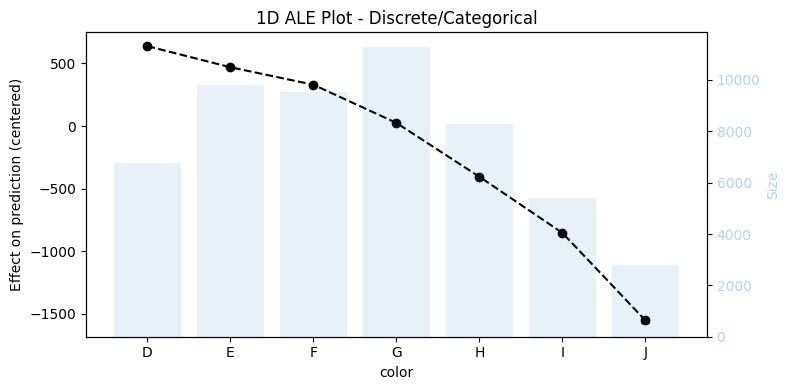

In [20]:
## 1D - categorical
ale_eff = ale(
    X=X_feat_raw,
    model=model,
    feature=["color"],
    encode_fun=onehot_encode,
    predictors=features,
)

### another categorical feature with a custom encoding fucntion

In [21]:
def numeric_encode(col_df):
    feat_name = col_df.columns[0]
    encoding = X[[feat_name, feat_name + '_code']].drop_duplicates()
    encode_dict = {v[feat_name]:v[feat_name + '_code'] for i, v in encoding.iterrows()}
    ret_df = pd.DataFrame({feat_name + '_code': [encode_dict.get(k) for k in col_df.values.ravel()]})
    return ret_df

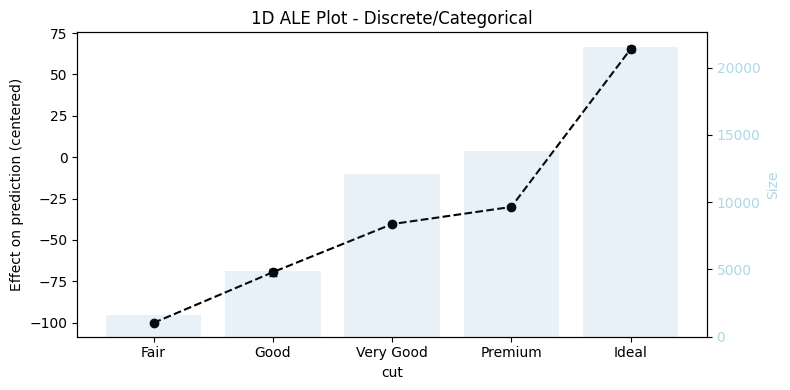

In [22]:
# just like the previous example we need to work with the raw feature and not the encoding
# since X already has the raw feature it is enough to drop its encoding columns 
X_feat_raw = X.drop('cut_code', axis=1, inplace=False).copy()
eff_df = ale(X=X_feat_raw, 
             model=model,
             feature=['cut'],
             encode_fun=numeric_encode, 
             predictors=features,
             include_CI=True, 
             C=0.9)

In [23]:
X_feat_raw = X.drop('cut_code', axis=1, inplace=False).copy()
a = ALE_1D_IS.aleplot_1D_categorical2(X=X_feat_raw, model=model, feature="cut", encode_fun=numeric_encode, predictors=features, include_CI=True, C=0.95, verbose=True)
a

2024-05-01 22:40:54.205 | INFO     | PyALE._src.ALE_1D_IS:aleplot_1D_categorical2:534 - Starting of aleplot_1D_categorical2
2024-05-01 22:40:54.206 | WARNING  | PyALE._src.ALE_1D_IS:aleplot_1D_categorical2:535 - Start: Data types check of the function
2024-05-01 22:40:54.208 | WARNING  | PyALE._src.ALE_1D_IS:aleplot_1D_categorical2:542 - End: Data types check of the function
2024-05-01 22:40:54.208 | DEBUG    | PyALE._src.ALE_1D_IS:aleplot_1D_categorical2:547 - If condition:if (X[feature].dtype.name != 'category') or (not X[feature].cat.ordered):False
2024-05-01 22:40:57.146 | INFO     | PyALE._src.lib:CI_estimate:187 - Starting of CI_estimate
2024-05-01 22:40:57.148 | DEBUG    | PyALE._src.lib:CI_estimate:188 - x_vec shape:(0,)
2024-05-01 22:40:57.148 | DEBUG    | PyALE._src.lib:CI_estimate:189 - Here the population variance is not know so t distribution is used for testing.
2024-05-01 22:40:57.149 | DEBUG    | PyALE._src.lib:CI_estimate:193 - The standard deviation will be divided by

,eff,size,lowerCI_95%,upperCI_95%
cut,,,,
Fair,-100.172437,1610,NaN,NaN
Good,-69.551269,4906,-72.181457,-66.921081
Very Good,-40.464307,12082,-41.734123,-39.194491
Premium,-30.086004,13791,-31.129829,-29.042180
Ideal,65.254605,21551,63.078812,67.430398


In [25]:
X_feat_raw = X.drop(coded_feature.columns.to_list(), axis=1, inplace=False).copy()
b = ALE_1D_IS.aleplot_1D_categorical2(X=X_feat_raw, model=model, feature="color", encode_fun=onehot_encode, predictors=features, include_CI=True, C=0.95, verbose=True)
b

2024-05-01 22:43:22.007 | INFO     | PyALE._src.ALE_1D_IS:aleplot_1D_categorical2:534 - Starting of aleplot_1D_categorical2
2024-05-01 22:43:22.008 | WARNING  | PyALE._src.ALE_1D_IS:aleplot_1D_categorical2:535 - Start: Data types check of the function
2024-05-01 22:43:22.010 | WARNING  | PyALE._src.ALE_1D_IS:aleplot_1D_categorical2:542 - End: Data types check of the function
2024-05-01 22:43:22.013 | DEBUG    | PyALE._src.ALE_1D_IS:aleplot_1D_categorical2:547 - If condition:if (X[feature].dtype.name != 'category') or (not X[feature].cat.ordered):True
2024-05-01 22:43:22.013 | DEBUG    | PyALE._src.ALE_1D_IS:aleplot_1D_categorical2:549 - If condition:if (X[feature].dtype.name != 'category'):True
2024-05-01 22:43:22.013 | DEBUG    | PyALE._src.ALE_1D_IS:aleplot_1D_categorical2:551 - If condition:if (X[feature].dtype.name != 'category') or (not X[feature].cat.ordered):True
2024-05-01 22:43:22.320 | DEBUG    | PyALE._src.ALE_1D_IS:aleplot_1D_categorical2:555 - type(groups_order.index.value

,eff,size,lowerCI_95%,upperCI_95%
color,,,,
D,637.878462,6775,NaN,NaN
E,469.732779,9797,463.682068,475.783491
F,329.730834,9542,325.676729,333.784938
G,24.889515,11292,17.400330,32.378700
H,-405.224853,8304,-415.817725,-394.631980
I,-853.460545,5422,-864.192200,-842.728890
J,-1552.169653,2808,-1571.823596,-1532.515709
